# Análisis de Densidad de Fuentes de Corriente en la escala de las neuronas en 2D

En este cuaderno de Julia mostraremos las técnicas analíticas y numéricas desarrolladas en el Laboratorio 19 del CINVESTAV Coapa para la obtención de la densidad de fuentes de corriente en rebanadas ventrales del hipocámpo de la rata común. El análisis es un extensión cuidadosa tomando en cuenta las limitaciones de resolución de los aparatos con los que contamos y extendiendo los tratamientos téoricos generales hechos por Bédard y Destexhe (2011) y Pettersen *et all* (2006) y varios otros.

Comenzemos por lo primero: asumiremos que la conductividad no es constante, y la corriente está restringida a moverse en el plano del corte. La expresión entonces para la densidad de fuentes de corriente es:
 $$\begin{equation}
 \begin{split}
 -I_m= & (\partial_x \sigma_{xx}) (\partial_x \phi) +
  (\partial_y \sigma_{yy}) (\partial_y \phi)\\
& +(\partial_x \sigma_{xy}) (\partial_y \phi) +(\partial_y \sigma_{xy}) (\partial_x \phi)\\
& + 2\sigma_{xy} \partial_x\partial_y \phi \\
& + \sigma_{xx} \partial_x^2 \phi + \sigma_{yy} \partial_y^2 \phi.
 \end{split}
 \end{equation}
 $$

Normalmente, se toma en cuenta sólo el último renglón de la expresión anterior, lo cual equivale a asumir que el medio es isotrópico y homogeneo. Sin emargo, mediciones llevadas a cabo ya hace tiempo (Holzheimer 1987) indican claramente que la conductividad varia hasta 40% de su valor promedio a lo largo de la dirección axonal-apical. Aquí mantendremos la suposición de isotropía, es decir,
$$\begin{equation}
\begin{split}
\sigma_{xx}=\sigma_{yy}=\sigma \\
\sigma_{xy}=0
\end{split}
\end{equation}
$$
pero consideraremos variaciones en la conductividad en la escala que nos interesa (es decir, entre $20 \mu m$ y $50 \mu m$:
$$\begin{equation}
\partial_x \sigma, \partial_y \sigma \neq 0
\end{equation}$$.

Comenzemos por cargar un ejemplo de medidas del potencial eléctrico de campo local (LFP) de un instante dado. Estos datos ya fueron adecuadamente limpiados del ruido asociado a la frecuencia de la corriente eléctrica en México y de ruido asociado a la naturaleza del aparato de medición.

In [2]:
LFPexample=readdlm("../LFP/LFPSuave-990.dat");

Definamos los operadores diferenciales numéricos:

In [35]:
function Gradiente2D(z::Array)
    #por cuestiones de ploteo, mejor dar dos matrices como resultado
    (alto,ancho)=size(z)
    vx=Array(Real, (alto,ancho))
    vy=Array(Real, (alto,ancho))
    aux=copy(z)
    aux=vcat(aux[1,:],aux,aux[end,:])
    aux=hcat(aux[:,1],aux,aux[:,end])
    for j=2:alto+1, k=2:ancho+1
        #Derivada de la secante
        dfdx=aux[j,k+1]-aux[j,k-1]
        #los arreys tienen un eje y invertido. Su y es la -y cartesiana
        dfdy=(aux[j+1,k]-aux[j-1,k]) 
        (vx[j-1,k-1], vy[j-1,k-1])=(dfdx, dfdy)
    end
    return (vx, vy)
end

        
function Divergencia2D(z::Array)
    (alto,ancho)=size(z)
    result=Array(Real, (alto,ancho))
    aux=copy(z)
    aux=vcat(aux[1,:],aux,aux[end,:])
    aux=hcat(aux[:,1],aux,aux[:,end])
    for j=2:alto+1, k=2:ancho+1
        #Derivada de la secante
        vx2=aux[j,k+1][1]
        vx1=aux[j,k-1][1]
        vy2=aux[j+1,k][2]
        vy1=aux[j-1,k][2] 
        dvxdx=vx2-vx1
        #los arreys tienen un eje y invertido. Su y es la -y cartesiana
        dvydy=-(vy2-vy1)
        result[j-1,k-1]=dvxdx+dvydy
    end
    return result
end

        
function Divergencia2D(Ex::Array, Ey::Array)
    (alto,ancho)=size(Ex)
    result=Array(Real, (alto,ancho))
    (auxEx,auxEy)=(copy(Ex),copy(Ey))

    auxEx=vcat(auxEx[1,:],auxEx,auxEx[end,:])
    auxEx=hcat(auxEx[:,1],auxEx,auxEx[:,end])
    
    auxEy=vcat(auxEy[1,:],auxEy,auxEy[end,:])
    auxEy=hcat(auxEy[:,1],auxEy,auxEy[:,end])

    for j=2:alto+1, k=2:ancho+1
        #Derivada de la secante
        vx2=auxEx[j,k+1]
        vx1=auxEx[j,k-1]
        vy2=auxEy[j+1,k]
        vy1=auxEy[j-1,k] 
        dvxdx=vx2-vx1
        #los arreys tienen un eje y invertido. Su y es la -y cartesiana
        dvydy=(vy2-vy1)
        result[j-1,k-1]=dvxdx+dvydy
    end
    return result
end

LaplacianKernel=zeros(3,3);
#checa que Julia va ordenando los datos renglon por renglon, no columna por columna
LaplacianKernel=[[0.5 1. 0.5], [1. -6. 1], [0.5 1. 0.5]];

function DiscreteLaplacian(Datos)
    result=zeros(Datos)
    temp=copy(Datos)
    #Primero, hacemos el padding de los datos para que no se suavice demasiado
    temp=vcat(temp[1,:], temp, temp[end,:])
    temp=hcat(temp[:,1], temp, temp[:,end])
    largo,ancho=size(Datos)
    aux=Array(Float64,(3,3))
    result=zeros(Datos)
    for j=2:largo+1, k=2:ancho+1
        #los indices van primero, "renglones", luego "columnas", etc
        aux=temp[j-1:j+1,k-1:k+1]
        result[j-1,k-1]=sum(LaplacianKernel.*aux)
    end
    return result
end


DiscreteLaplacian (generic function with 1 method)

Obtengamos el campo eléctrico local a partir del potencial:

In [4]:
(EFx,EFy)=Gradiente2D(-LFPexample);

Dibujemos los vectores del campo eléctrico y sus lineas de fuerza:

In [21]:
using PyPlot

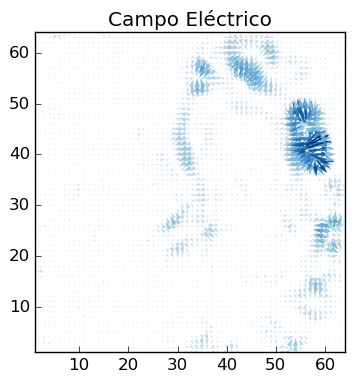

In [41]:
x=1:64
y=1:64
PyPlot.ion()
figure(figsize=(4,4), frameon=false)
PyPlot.title("Campo Eléctrico")
xlim(1,64)
ylim(1,64)
#clim(0,120)
flechitas=quiver(x,y,EFx,EFy, sqrt((EFx.*EFx+EFy.*EFy)), 
pivot="middle", cmap="Blues", width=0.006);
tick_params(          # changes apply to the x-axis
    which="both",      # both major and minor ticks are affected
    bottom="on",# ticks along the bottom edge are off
    top="off",         # ticks along the top edge are off
right="off",
left="on",
    labelbottom="on",
labelleft="on")
savefig("EjemplitoFlechasEF01.png", dpi=72)

Incorporemos un modelo cualitativo de la conductividad a lo largo del stratum piramidale y el centro del giro dentado. Propongo una extensión a lo largo de las estructuras mencionadas que respete la forma de la variación de la resistividad medida por Holzheimer 1987, cuyo perfil transversal a s.pyr. tenga el mismo comportamiento cualitativo.

In [18]:
cond=float64(readdlm("ModeloConductividad02.dat"));

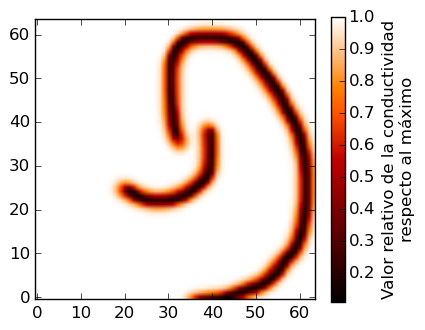

In [46]:
figure(figsize=(4,4))
imagencond=imshow(cond,cmap="gist_heat", origin="lower")
cbx=colorbar(imagencond, fraction=0.046) 
cbx[:set_label]("Valor relativo de la conductividad 
respecto al máximo")

Podemos comparar ahora el campo eléctrico $\vec{E}$ contra la densidad de corriente $\vec{J}$:

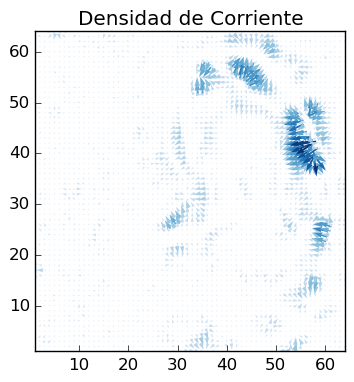

In [47]:
x=1:64
y=1:64
PyPlot.ion()
figure(figsize=(4,4), frameon=false)
PyPlot.title("Densidad de Corriente")
xlim(1,64)
ylim(1,64)
#clim(0,120)
Jx=EFx.*cond
Jy=EFy.*cond
flechitas=quiver(x,y,Jx,Jy, sqrt((Jx.*Jx+Jy.*Jy)), 
pivot="middle", cmap="Blues", width=0.006);
tick_params(          # changes apply to the x-axis
    which="both",      # both major and minor ticks are affected
    bottom="on",# ticks along the bottom edge are off
    top="off",         # ticks along the top edge are off
right="off",
left="on",
    labelbottom="on",
labelleft="on")
savefig("DensidadDeCorrienteEjemplo01.png", dpi=72)

Ahora bien, con las consideraciones generales que tenemos, la CSD tendrá la siguiente expresión (usando los operadores en el espacio cartesiano en 2D):
$$\begin{equation}
\begin{split}
 I_m= & -\nabla \sigma \cdot \nabla \phi
& - \sigma \nabla^2 \phi.
 \end{split}
 \end{equation}
 $$
 Procedamos a obtener el gradiante de la conductividad:

In [16]:
(condprimax,condprimay)=Gradiente2D(cond);

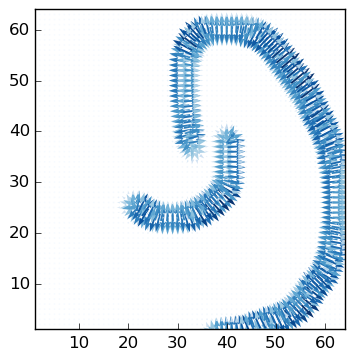

In [48]:
figure(figsize=(4,4))
xlim(1,64)
ylim(1,64)

#clim(0,120)
flechitas=quiver(x,y,condprimax,condprimay, 
sqrt((condprimax.*condprimax+condprimay.*condprimay)), 
pivot="middle", cmap="Blues", width=0.006);
tick_params(          # changes apply to the x-axis
    which="both",      # both major and minor ticks are affected
    bottom="on",# ticks along the bottom edge are off
    top="off",         # ticks along the top edge are off
right="off",
left="on",
    labelbottom="on",
labelleft="on")

Veamos el término $-\nabla \sigma \cdot \nabla \phi$

In [28]:
TerminoGradientes=condprimax.*EFx+condprimay*EFy;

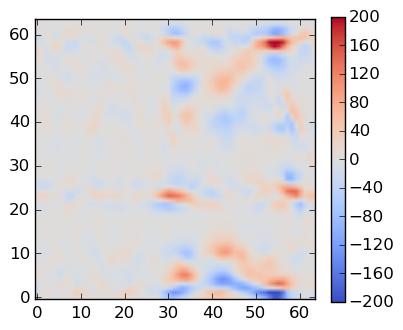

PyObject <matplotlib.colorbar.Colorbar object at 0x7fb47e5d8c18>

In [51]:
figure(figsize=(4,4))
#xlim(1,64)
#ylim(1,64)
PrimerTerminoImagen=imshow(TerminoGradientes, cmap="coolwarm", origin="lower", vmin=-200, vmax=200)
cb=colorbar(PrimerTerminoImagen, fraction=0.046)

Y ahora el termino del Laplaciano, $-\sigma \nabla^2 \phi$

In [37]:
TerminoLaplaciano=-cond.*DiscreteLaplacian(LFPexample);

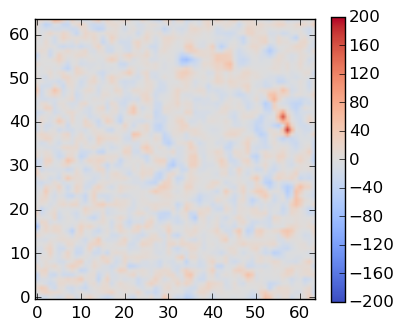

PyObject <matplotlib.colorbar.Colorbar object at 0x7fb45b5f30b8>

In [52]:
figure(figsize=(4,4))
#xlim(1,64)
#ylim(1,64)
PrimerTerminoImagen=imshow(TerminoLaplaciano, cmap="coolwarm", origin="lower", vmin=-200,vmax=200)
cb=colorbar(PrimerTerminoImagen, fraction=0.046)

La Densidad de fuentes de corriente sería la suma de ambos términos:

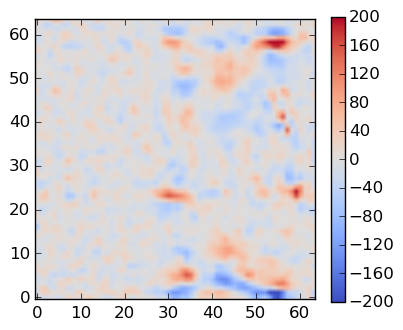

PyObject <matplotlib.colorbar.Colorbar object at 0x7fb45b708ef0>

In [53]:
CSDExample=TerminoGradientes+TerminoLaplaciano
figure(figsize=(4,4))
#xlim(1,64)
#ylim(1,64)
CSDImagen=imshow(CSDExample, cmap="coolwarm", origin="lower", vmin=-200,vmax=200)
cb=colorbar(PrimerTerminoImagen, fraction=0.046)

La aproximación naïve ($I_m \propto -\nabla^2 \phi$) nos daría

In [55]:
CSDNaive=-DiscreteLaplacian(LFPexample);

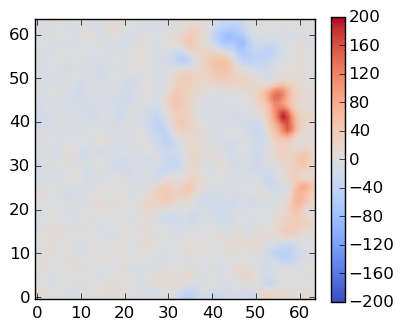

PyObject <matplotlib.colorbar.Colorbar object at 0x7fb45b3aa470>

In [56]:
figure(figsize=(4,4))
#xlim(1,64)
#ylim(1,64)
CSDImagen=imshow(LFPexample, cmap="coolwarm", origin="lower", vmin=-200,vmax=200)
cb=colorbar(PrimerTerminoImagen, fraction=0.046)